In [196]:
!python -m spacy download es_core_news_lg -q
import spacy
nlp=spacy.load("es_core_news_lg")
ruler = nlp.add_pipe("entity_ruler")

[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [148]:
import nltk
import pandas as pd
import numpy as np
from IPython.display import display
!pip install --upgrade matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
import re
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import joblib
from joblib import load 
from joblib import dump
from sklearn.utils import shuffle
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Samuel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Samuel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Samuel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [197]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.utils import shuffle

In [198]:
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^\w\s]', '', texto)  
    texto = re.sub(r'\d+', '', texto)     
    palabras =word_tokenize(texto)
    doc = nlp(' '.join(palabras))
    palabras = [token.lemma_ for token in doc]
    return ' '.join(palabras)


In [199]:
df=pd.read_csv('Sentimento_completo.csv')
df_guion=df[df['Label']=='GUION']
df_guion=df_guion.reset_index(drop=True)
df_guion


,Unnamed: 0,Label,Entity,Review,continent
0,6,GUION,trama,la trama se siente un poco forzada.,EEUU
1,7,GUION,guion,pero el guion no tiene el mismo impacto emocional que la primera película.,EEUU
2,11,GUION,guion,el guion carece de profundidad y los personajes no generan la misma empatía que en la primera entrega.,EUROPE
3,15,GUION,historia,Aunque la historia no logra el mismo impacto emocional que su predecesora,EEUU
4,18,GUION,narrativa,la falta de un personaje tan icónico como Máximo resta un poco de fuerza a la narrativa.,EUROPE
5,22,GUION,guion,el guion es predecible y poco inspirado.,EEUU
6,25,GUION,historia,pero carece de una historia realmente atrapante.,EEUU
7,27,GUION,guion,pero no logra salvar del todo el guion.,EEUU
8,31,GUION,historia,Las batallas son emocionantes y la historia,EEUU
9,34,GUION,historia,"la historia de ""Gladiator 2"" no logra cautivar de la misma manera que la primera.",EEUU


In [204]:
entidades_semanticas = {
    "GENERAL": {"tipo_semantico":"Entidad","entidades":["Gladiator 2","secuela","continuacion"]},
    "DIRECTOR": {"tipo_semantico": "Persona", "entidades": ["Ridley Scott"]},
    "ACTOR": {"tipo_semantico": "Persona", "entidades": ["Paul Mescal", "Denzel Washington", "Pedro Pascal"]},
    "PRODUCCION": {"tipo_semantico": "Objeto Fílmico", "entidades": ["Ridley Scott","producción","visual", "escenas", "efectos especiales","coreografias","música"]},
    "GUION": {"tipo_semantico": "Objeto escrito", "entidades": ["trama","historia","narrativa","guion"]}
}

In [206]:
patterns = []
for categoria, datos in entidades_semanticas.items():
    for entidad in datos["entidades"]:
        patterns.append({"label": categoria, "pattern": entidad})
ruler.add_patterns(patterns)

In [222]:
model_X= load("modelo_SVC.pkl")
vectorizer=load("vectorizador_tfidf.pkl")


In [224]:

mapeo_sentimientos = {-1: 'NEG', 0: 'NEU',1: 'POS'}
#predictions.clear
predictions=[]
for index,row in df_guion.iterrows():
    comentarios=row['Review']
    continente=row['continent']
    label=row['Label']
    entity=row['Entity']
    text=limpiar_texto(comentarios)
    text_vec=vectorizer.transform([text])
    pred=model_X.predict(text_vec) 
    sent_map = mapeo_sentimientos[pred[0]]
    text_pred=label,entity,comentarios,continente,sent_map
    predictions.append(text_pred)
pd.set_option('display.max_colwidth', None)
   
Df_Guion=pd.DataFrame(predictions,columns=['Label','Entity','Review','Continent','Sentiment'])
Df_Guion = Df_Guion.drop_duplicates(subset=['Review'], keep='first')
pd.set_option('display.max_colwidth', None)
Df_Guion.to_csv('Script.csv')
Df_Guion


,Label,Entity,Review,Continent,Sentiment
0,GUION,trama,la trama se siente un poco forzada.,EEUU,NEG
1,GUION,guion,pero el guion no tiene el mismo impacto emocional que la primera película.,EEUU,NEU
2,GUION,guion,el guion carece de profundidad y los personajes no generan la misma empatía que en la primera entrega.,EUROPE,NEG
3,GUION,historia,Aunque la historia no logra el mismo impacto emocional que su predecesora,EEUU,NEU
4,GUION,narrativa,la falta de un personaje tan icónico como Máximo resta un poco de fuerza a la narrativa.,EUROPE,NEG
5,GUION,guion,el guion es predecible y poco inspirado.,EEUU,NEG
6,GUION,historia,pero carece de una historia realmente atrapante.,EEUU,NEG
7,GUION,guion,pero no logra salvar del todo el guion.,EEUU,NEG
8,GUION,historia,Las batallas son emocionantes y la historia,EEUU,NEU
9,GUION,historia,"la historia de ""Gladiator 2"" no logra cautivar de la misma manera que la primera.",EEUU,NEG


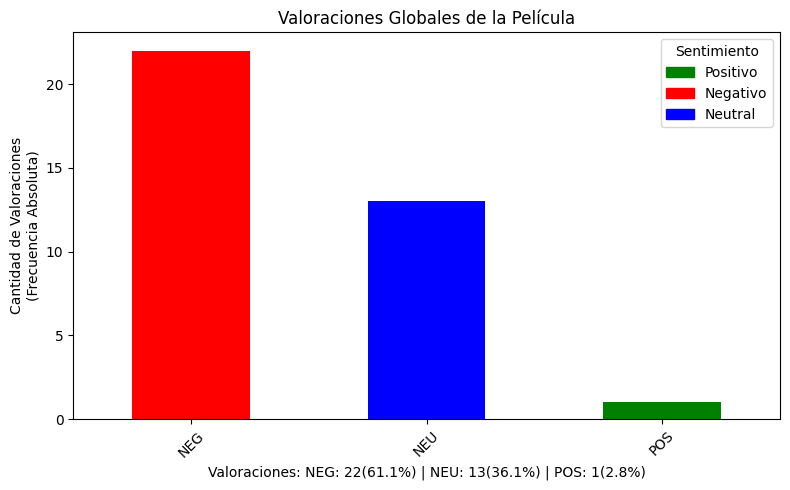

In [226]:
Guion_sentiment= Df_Guion['Sentiment'].value_counts()
frecuency_rel = Guion_sentiment / Guion_sentiment.sum() * 100 
category=['POS', 'NEU', 'NEG']
Guion_sentiment2 = Guion_sentiment.reindex(category, fill_value=0)
colors= {'POS': 'green', 'NEG': 'red', 'NEU': 'blue'}
ax=Guion_sentiment.plot(kind='bar',figsize=(8, 5),color=[colors[label] for label in Guion_sentiment.index])
plt.title('Valoraciones Globales de la Película')
sentiment_text = " | ".join([f"{key}: {value}({frecuency_rel[key]:.1f}%)" for key, value in Guion_sentiment.items()])
plt.xlabel(f"Valoraciones: {sentiment_text}")
plt.ylabel('Cantidad de Valoraciones\n(Frecuencia Absoluta)' )
plt.xticks(rotation=45)
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in colors.keys()]
labels = ['Positivo', 'Negativo', 'Neutral']  # Describe los colores en la leyenda
plt.legend(handles, labels, title='Sentimiento', loc='upper right')

plt.tight_layout()

plt.show()

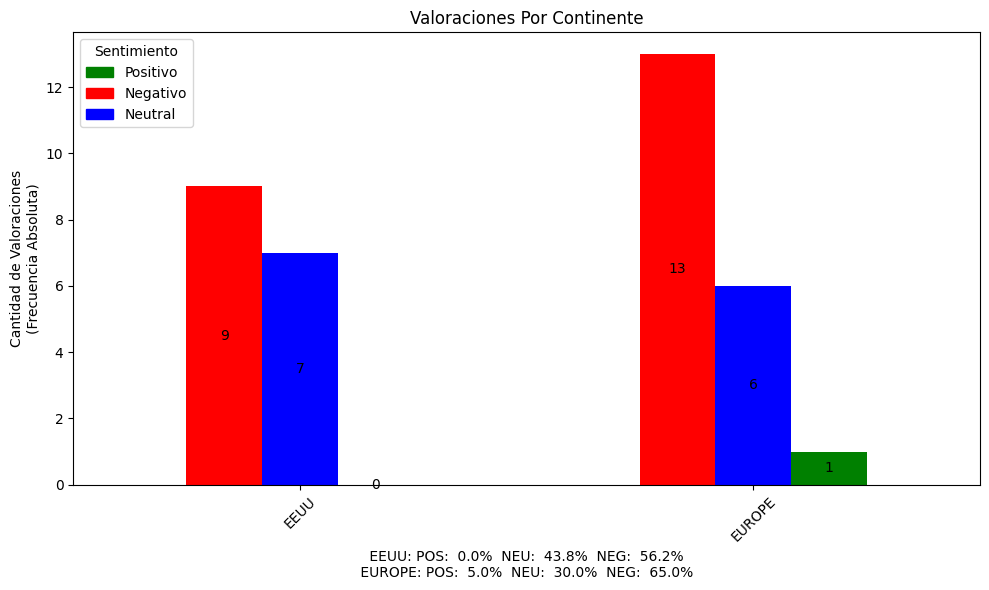

In [228]:
Guion_cont_sentiment =  Df_Guion.groupby(['Continent', 'Sentiment']).size().unstack(fill_value=0)

# Crear gráfico de barras apiladas
ax=Guion_cont_sentiment.plot(kind='bar', stacked=False, figsize=(10, 6), color={'POS': 'green', 'NEG': 'red','NEU':'blue'})
frecuencia_rel= Guion_cont_sentiment.div(Guion_cont_sentiment.sum(axis=1), axis=0) * 100
frecuencia_rel= frecuencia_rel.reindex(columns=category, fill_value=0)
frecuencia_text ="\n ".join([
    f"{continent}: "+" ".join([f"{col}:  {frecuencia_rel.loc[continent, col]:.1f}% " for col in frecuencia_rel.columns])
    for continent in frecuencia_rel.index
])
plt.title('Valoraciones Por Continente')
plt.xlabel(f" {frecuencia_text}")
plt.ylabel('Cantidad de Valoraciones\n(Frecuencia Absoluta)')
plt.xticks(rotation=45)
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in colors.keys()]
labels = ['Positivo', 'Negativo', 'Neutral']  # Describe los colores en la leyenda
plt.legend(handles, labels, title='Sentimiento', loc='upper left')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='center') 
plt.tight_layout()
plt.show()